#### [PyTorch를 활용한 머신러닝, 딥러닝 철저 입문]
## [Chapter 7-4] 예제: ants & bees 이미지 분류

---

## \#0. Download Data

다음 주소에서 데이터를 다운로드 한다.

> https://download.pytorch.org/tutorial/hymenoptera.zip

이 중 `train`, `val` 폴더에 있는 `ants`와 `bees`의 이미지를 다음과 같은 구조로 정리한다.

In [1]:
!tree -d ./data/hymenoptera_data

./data/hymenoptera_data
├── ants
└── bees

2 directories


위와 같이 `hymenoptera_data`의 하위 디렉터리로 `ants`와 `bees` 를 생성해서 각각 193장, 204장의 이미지를 넣었다.

---

## \#1. Import Modules

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os

from PIL import Image

import numpy as np

import pandas as pd

from sklearn import datasets, model_selection

---

## \#2. Conversion : Image data → numpy array

### 2-1. show sample Image file

먼저 sample 이미지를 확인하자.

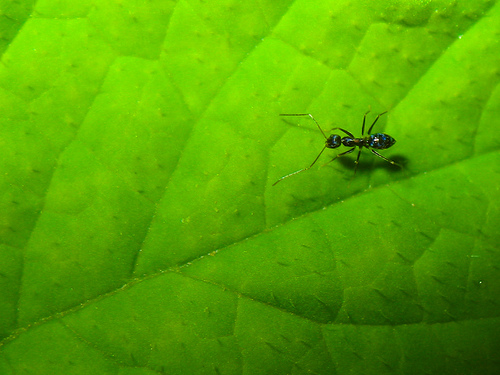

In [3]:
ant_files = os.listdir('./data/hymenoptera_data/' + 'ants')
ant_img = Image.open('./data/hymenoptera_data/' + 'ants' + '/' + ant_files[0], 'r')
ant_img

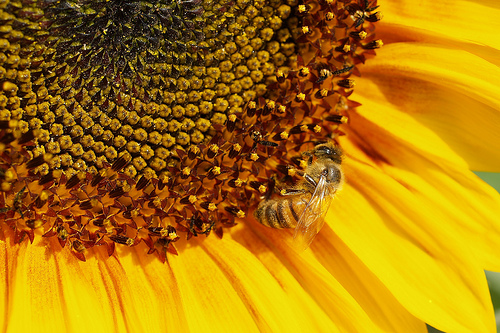

In [4]:
bee_files = os.listdir('./data/hymenoptera_data/' + 'bees')
bee_img = Image.open('./data/hymenoptera_data/' + 'bees' + '/' + bee_files[0], 'r')
bee_img

Pillow 패키지로 정상적으로 읽을 수 있음을 확인

### 2-2. `data`, `label` list

- data와 label이 담길 list를 초기화한다.

In [5]:
data = list()
label = list()

### 2-3. Get files from directory

- file들을 directory에서 하나씩 가져와서 저장

In [6]:
dirs = ['ants', 'bees']

for idx, directory in enumerate(dirs):
    
    # file 목록 생성
    files = os.listdir('./data/hymenoptera_data/' + directory)
    
    # file 별로 이미지 저장
    for f in files:
        
        # 이미지 열기
        img = Image.open('./data/hymenoptera_data/' + directory + '/' + f, 'r')
        
        # 128 * 128 로 리사이징
        resize_img = img.resize((128, 128))
        
        # 채널별로 분리해서 [0, 1] 구간으로 정규화
        r, g, b = resize_img.split()
        
        r_resize_img = np.asarray(np.float32(r) / 255)
        g_resize_img = np.asarray(np.float32(g) / 255)
        b_resize_img = np.asarray(np.float32(b) / 255)
        
        rgb_resize_img = np.asarray([r_resize_img, g_resize_img, b_resize_img])
        
        # 리스트에 data, label 추가
        data.append(rgb_resize_img)
        label.append(idx)

### 2-4. Show saved dataz

#### 저장된 데이터 확인 : `193 + 204 = 394` 장의 이미지

In [7]:
len(data), len(label)

(397, 397)

#### data에 있는 값 확인

In [8]:
len(data[0])

3

- data의 각 요소에는 3가지 이미지 array (`r`, `g`, `b`)가 들어있음을 확인할 수 있다.

#### DataFrame으로 image shape 확인

In [9]:
print(pd.DataFrame(data[0][0]).shape)
pd.DataFrame(data[0][0]).tail()

(128, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
123,0.215686,0.227451,0.184314,0.243137,0.200000,0.215686,0.247059,0.262745,0.266667,0.254902,...,0.145098,0.098039,0.094118,0.094118,0.133333,0.098039,0.090196,0.105882,0.090196,0.078431
124,0.211765,0.223529,0.207843,0.243137,0.239216,0.282353,0.298039,0.274510,0.266667,0.286275,...,0.101961,0.105882,0.098039,0.101961,0.090196,0.090196,0.098039,0.098039,0.090196,0.082353
125,0.196078,0.250980,0.235294,0.250980,0.278431,0.298039,0.321569,0.286275,0.286275,0.286275,...,0.086275,0.090196,0.074510,0.094118,0.113725,0.121569,0.117647,0.105882,0.098039,0.094118
126,0.211765,0.219608,0.254902,0.231373,0.227451,0.301961,0.247059,0.254902,0.282353,0.278431,...,0.094118,0.094118,0.098039,0.105882,0.094118,0.082353,0.090196,0.105882,0.105882,0.090196
127,0.184314,0.207843,0.270588,0.254902,0.262745,0.262745,0.274510,0.250980,0.262745,0.294118,...,0.133333,0.098039,0.086275,0.109804,0.105882,0.098039,0.086275,0.086275,0.078431,0.094118


- 각 이미지 array는 `128 * 128` 의 숫자값들이 들어있음을 확인할 수 있다.

#### numpy array로 변환

In [10]:
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

---

## \#3. Training / Test Data

### 3-1. Get Train / Test data by `train_test_split`

train data는 70000개의 데이터 중 5000개, test data는 500개를 추출하기로 한다.

In [11]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(data, label, test_size=0.1)

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(357, 3, 128, 128) (357,)
(40, 3, 128, 128) (40,)


train 데이터는 357건, test 데이터는 40건으로 10%의 비율로 생성되었다.

---

## \#4. Make Tensor

### 4-1. Transform Data Type

#### 완성된 train, test 데이터를 PyTorch의 `tensor 데이터`로 변환한다.

In [12]:
# train data
train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(train_y).long()

# test data
test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).long()

train_X.shape, train_y.shape

(torch.Size([357, 3, 128, 128]), torch.Size([357]))

#### train의 X와 y데이터를 `tensorDataset` 으로 합친다.

In [13]:
train = TensorDataset(train_X, train_y)
train[0][0].shape, train[0][1]

(torch.Size([3, 128, 128]), tensor(0))

- train의 각 element들은 feature와 label의 쌍으로 이루어져있음을 확인
- 첫 번째 쌍은 `128 x 128`의 2차원 텐서와, `0`이라는 label의 쌍으로 이루어져 있다.


- 이번 데이터는 **채널이 3개 (r, g, b)** 이므로 입력 채널을 3으로 해주어야 한다!

### 4-2. Mini Batch

#### train 데이터를 미니배치로 학습시킬 수 있도록 `32개` 단위로 분할한다.

In [14]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)

---

## \#5. Neural Network Composition

### 5-1. Neural Network class

In [15]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 합성곱층
        self.conv1 = nn.Conv2d(3, 10, 5) #(입력 채널 수, 출력 채널 수, 필터크기)
        self.conv2 = nn.Conv2d(10, 20, 5)
        
        # 완전연결층
        # 입력노드수 : (((128-5+1) / 2) -5+1) / 2 = 29
        self.func1 = nn.Linear(29 * 29 * 20, 50)
        self.func2 = nn.Linear(50, 2)
        
        
    def forward(self, x):
        # 입력층 - 합성곱1층
        x = F.relu(self.conv1(x))
        # 풀링1층 : 풀링크기 2
        x = F.max_pool2d(x, 2)
        # 합성곱2층
        x = F.relu(self.conv2(x))
        # 풀링2층 : 풀링크기 2
        x = F.max_pool2d(x, 2)
        
        # len = 256의 1차원 텐서로 풀어주기
        x = x.view(-1, 29 * 29 * 20)
        
        # 완전연결층
        x = F.relu(self.func1(x))
        
        # 출력층
        x = self.func2(x)
        # 출력층 활성화함수 : log_softmax
        y = F.log_softmax(x, dim=1)
        
        return y

### 5-2. NN Instance 생성

In [16]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (func1): Linear(in_features=16820, out_features=50, bias=True)
  (func2): Linear(in_features=50, out_features=2, bias=True)
)

합성곱이 두 층 있고, 완전연결층과 출력층까지 확인

---

## \#6. Model Training

### 6-1. Loss Function

In [17]:
criterion = nn.CrossEntropyLoss()

### 6-2. Optimizer

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 6-3. Training

In [19]:
%%time
print("{} \t {}".format("epoch", "total loss"))
print("----- \t ----------------------")

for epoch in range(300):
    total_loss = 0
    
    for train_X, train_y in train_loader:
        
        # 계산 그래프 구성
        train_X, train_y = Variable(train_X), Variable(train_y)
        
        # gradient 초기화
        optimizer.zero_grad()
        
        # forward 계산
        output = model.forward(train_X)
        
        # loss 계산
        loss = criterion(output, train_y)
        
        # 오차 역전파
        loss.backward()
        
        # gradient update
        optimizer.step()
        
        # 누적 오차 계산
        total_loss += loss.data
        
    # 50번째 epoch마다 loss 출력    
    if (epoch+1) % 50 == 0:
        print("{} \t {}".format(epoch+1, total_loss))

epoch 	 total loss
----- 	 ----------------------
50 	 0.004212713334709406
100 	 0.0009501916356384754
150 	 0.0003699207736644894
200 	 0.0001795798889361322
250 	 0.0001092007732950151
300 	 6.784957076888531e-05
CPU times: user 22min 18s, sys: 3min 51s, total: 26min 9s
Wall time: 18min 44s


- `128 * 128` 이미지 357장을 학습시키는 데에 걸린 시간 : `18분 44초`

---

## \#7. Accuracy

### 7-1. test data 로 accuracy 계산

In [24]:
# 계산 그래프 구성
test_X, test_y = Variable(test_X), Variable(test_y)

# 결과를 0 또는 1이 되도록 변환
result = torch.max(model(test_X).data, 1)[1]

# test_y 와 결과가 같은 예측값의 개수 (맞춘 개수) 계산
accuracy = sum(test_y.data.numpy() == result.numpy()) / len(test_y.data.numpy())

accuracy

0.7

- 약 70% 의 정확도를 보인다.